<a href="https://www.kaggle.com/code/zeyadalmothafar/bigtech-tweets-sentiment-analysis?scriptVersionId=100749970" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/big-tech-companies-tweet-sentiment/Bigtech - 20-09-2020 till 13-10-2020.csv
/kaggle/input/big-tech-companies-tweet-sentiment/Bigtech - 12-07-2020 till 19-09-2020/Bigtech - 12-07-2020 till 19-09-2020.csv


In [2]:
df = pd.read_csv("/kaggle/input/big-tech-companies-tweet-sentiment/Bigtech - 20-09-2020 till 13-10-2020.csv")

In [3]:
df.head()

,created_at,file_name,followers,friends,group_name,location,retweet_count,screenname,search_query,text,twitter_id,username,polarity,partition_0,partition_1
0,2020-10-05 08:44:25,Nvidia,41,410,Nvidia,sydney,0,jyolyu,#Nvidia,#NVIDIA #GauGAN is actually a good tool to pra...,1313037313635565568,N0%Ice,0.4404,Technology,Nvidia
1,2020-10-05 08:44:03,Nvidia,367,267,Nvidia,PARIS,0,MiClaverie,#Nvidia,"#BullSequana X2415, the first #supercomputer b...",1313037222422118400,Michèle Claverie,0.0000,Technology,Nvidia
2,2020-10-05 08:41:35,Nvidia,14,104,Nvidia,Japan,0,_stingraze,#Nvidia,I'm going to attend GTC 2020 tonight! Excited....,1313036602675916802,Tsubasa Kato,0.4003,Technology,Nvidia
3,2020-10-05 08:28:11,Nvidia,18286,941,Nvidia,NaN,0,gamingonlinux,#Nvidia,#NVIDIA delays launch of #GeForce RTX 3070 unt...,1313033229201477634,GamingOnLinux 🐧,0.0000,Technology,Nvidia
4,2020-10-05 08:18:05,Nvidia,42,84,Nvidia,"Paris, France",0,anupdshetty,#Nvidia,"#BullSequana X2415, the first #supercomputer b...",1313030688338317312,Anup Shetty,0.0000,Technology,Nvidia


In [4]:
def basic_eda(df, row_limit=5, list_elements_limit=10):
    ### rows and columns
    print('Info : There are {} columns in the dataset'.format(df.shape[1]))
    print('Info : There are {} rows in the dataset'.format(df.shape[0]))
    
    print("==================================================")
    
    ## data types
    print("\nData type information of different columns")
    dtypes_df = pd.DataFrame(df.dtypes).reset_index().rename(columns={0:'dtype', 'index':'column_name'})
    cat_df = dtypes_df[dtypes_df['dtype']=='object']
    num_df = dtypes_df[dtypes_df['dtype']!='object']
    print('Info : There are {} categorical columns'.format(len(cat_df)))
    print('Info : There are {} numerical columns'.format(len(dtypes_df)-len(cat_df)))
    
    if list_elements_limit >= len(cat_df):
        print("Categorical columns : ", list(cat_df['column_name']))
    else:
        print("Categorical columns : ", list(cat_df['column_name'])[:list_elements_limit])
        
    if list_elements_limit >= len(num_df):
        print("Numerical columns : ", list(num_df['column_name']))
    else:
        print("Numerical columns : ", list(num_df['column_name'])[:list_elements_limit])
    
    #dtypes_df['dtype'].value_counts().plot.bar()
    display(dtypes_df.head(row_limit))
    
    print("==================================================")
    print("\nDescription of numerical variables")
    
    #### Describibg numerical columns
    desc_df_num = df[list(num_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_num.head(row_limit))
    
    print("==================================================")
    print("\nDescription of categorical variables")
    
    desc_df_cat = df[list(cat_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_cat.head(row_limit))
    
    return

# Explotary Data Analysis

In [5]:
basic_eda(df)

Info : There are 15 columns in the dataset
Info : There are 266095 rows in the dataset

Data type information of different columns
Info : There are 10 categorical columns
Info : There are 5 numerical columns
Categorical columns :  ['created_at', 'file_name', 'group_name', 'location', 'screenname', 'search_query', 'text', 'username', 'partition_0', 'partition_1']
Numerical columns :  ['followers', 'friends', 'retweet_count', 'twitter_id', 'polarity']


,column_name,dtype
0,created_at,object
1,file_name,object
2,followers,int64
3,friends,int64
4,group_name,object



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,followers,266095.0,9.584206e+03,1.293232e+05,0.000000e+00,6.300000e+01,3.310000e+02,1.786000e+03,1.382054e+07
1,friends,266095.0,2.275681e+03,1.253255e+04,0.000000e+00,8.600000e+01,3.410000e+02,1.416000e+03,1.162364e+06
2,retweet_count,266095.0,1.158041e+00,7.203702e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.709000e+04
3,twitter_id,266095.0,1.311613e+18,2.412275e+15,1.307470e+18,1.309467e+18,1.311562e+18,1.313763e+18,1.315804e+18
4,polarity,266095.0,1.783208e-01,3.999668e-01,-9.960000e-01,0.000000e+00,0.000000e+00,5.023000e-01,9.929000e-01



Description of categorical variables


,column_name,count,unique,top,freq
0,created_at,266095,227980,2020-10-06 17:36:26,28
1,file_name,266095,10,Twitch,40000
2,group_name,266095,10,Twitch,40000
3,location,196406,28748,United States,7947
4,screenname,266095,114999,iammab,5822


In [6]:
def polarity_to_sentiment(polarity):
    if polarity >= 0.5:
        return 'positive'
    else:
        return 'negative'

In [7]:
df['sentiment'] = df['polarity'].apply(polarity_to_sentiment)

In [8]:
df.head()

,created_at,file_name,followers,friends,group_name,location,retweet_count,screenname,search_query,text,twitter_id,username,polarity,partition_0,partition_1,sentiment
0,2020-10-05 08:44:25,Nvidia,41,410,Nvidia,sydney,0,jyolyu,#Nvidia,#NVIDIA #GauGAN is actually a good tool to pra...,1313037313635565568,N0%Ice,0.4404,Technology,Nvidia,negative
1,2020-10-05 08:44:03,Nvidia,367,267,Nvidia,PARIS,0,MiClaverie,#Nvidia,"#BullSequana X2415, the first #supercomputer b...",1313037222422118400,Michèle Claverie,0.0000,Technology,Nvidia,negative
2,2020-10-05 08:41:35,Nvidia,14,104,Nvidia,Japan,0,_stingraze,#Nvidia,I'm going to attend GTC 2020 tonight! Excited....,1313036602675916802,Tsubasa Kato,0.4003,Technology,Nvidia,negative
3,2020-10-05 08:28:11,Nvidia,18286,941,Nvidia,NaN,0,gamingonlinux,#Nvidia,#NVIDIA delays launch of #GeForce RTX 3070 unt...,1313033229201477634,GamingOnLinux 🐧,0.0000,Technology,Nvidia,negative
4,2020-10-05 08:18:05,Nvidia,42,84,Nvidia,"Paris, France",0,anupdshetty,#Nvidia,"#BullSequana X2415, the first #supercomputer b...",1313030688338317312,Anup Shetty,0.0000,Technology,Nvidia,negative


In [9]:
df['sentiment'].value_counts()

negative    199505
positive     66590
Name: sentiment, dtype: int64

# Companies Distribution in the Tweets

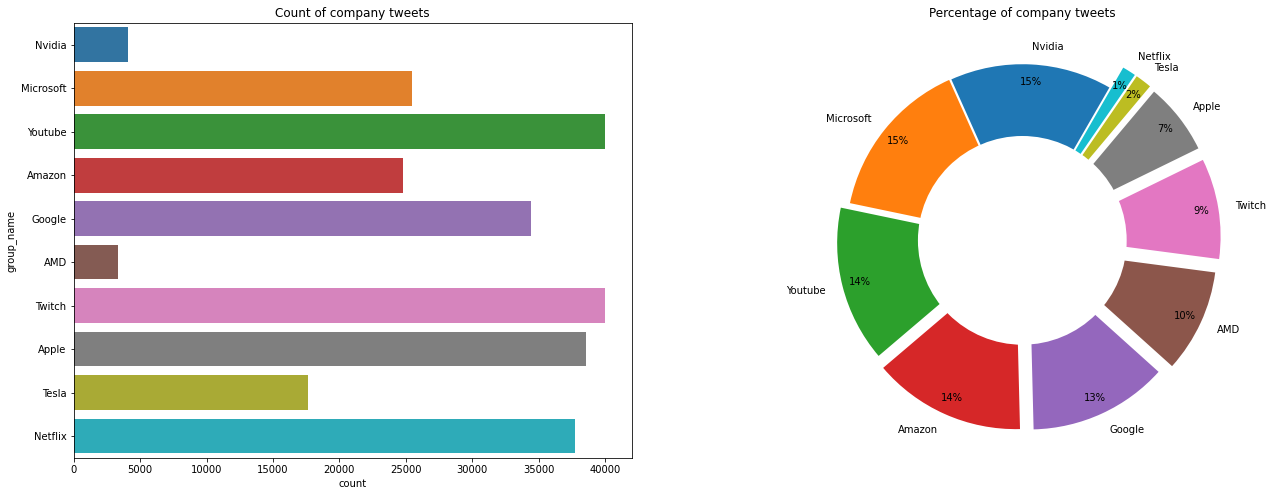

In [10]:
col = 'group_name'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(22,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1)
ax1.set_title("Count of company tweets")
ax2.set_title("Percentage of company tweets")
plt.show()

# Sentiment Distribution 

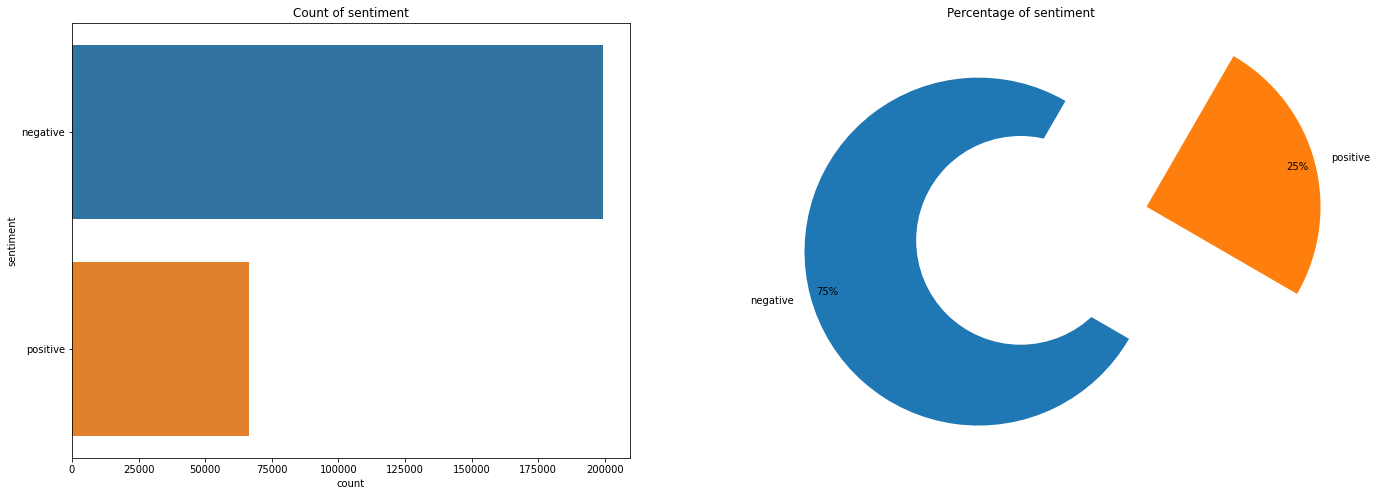

In [11]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(22,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1)
ax1.set_title("Count of sentiment")
ax2.set_title("Percentage of sentiment")
plt.show()

In [12]:
df['char_length'] = df['text'].apply(lambda x : len(x))
df['token_length'] = df['text'].apply(lambda x : len(x.split(" ")))

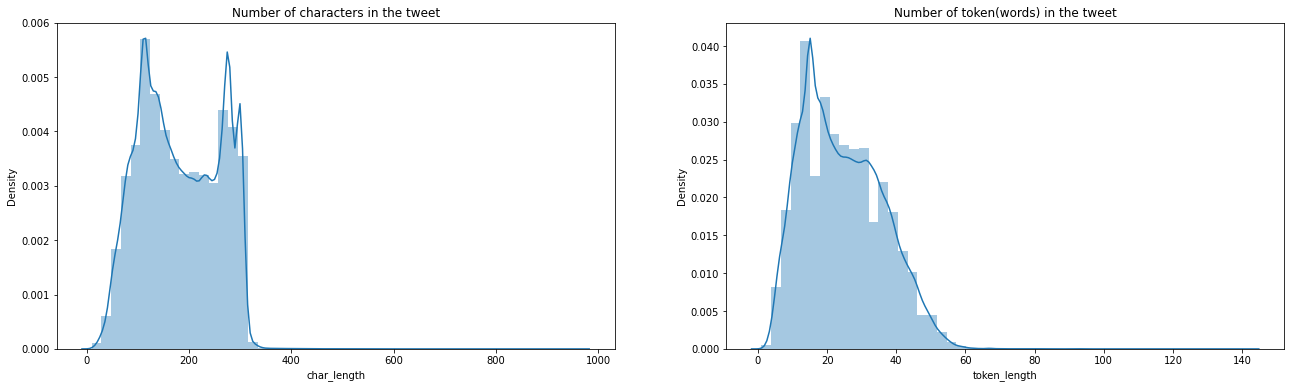

In [13]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(22,6))
sns.distplot(df['char_length'], ax=ax1)
sns.distplot(df['token_length'], ax=ax2)
ax1.set_title('Number of characters in the tweet')
ax2.set_title('Number of token(words) in the tweet')
plt.show()

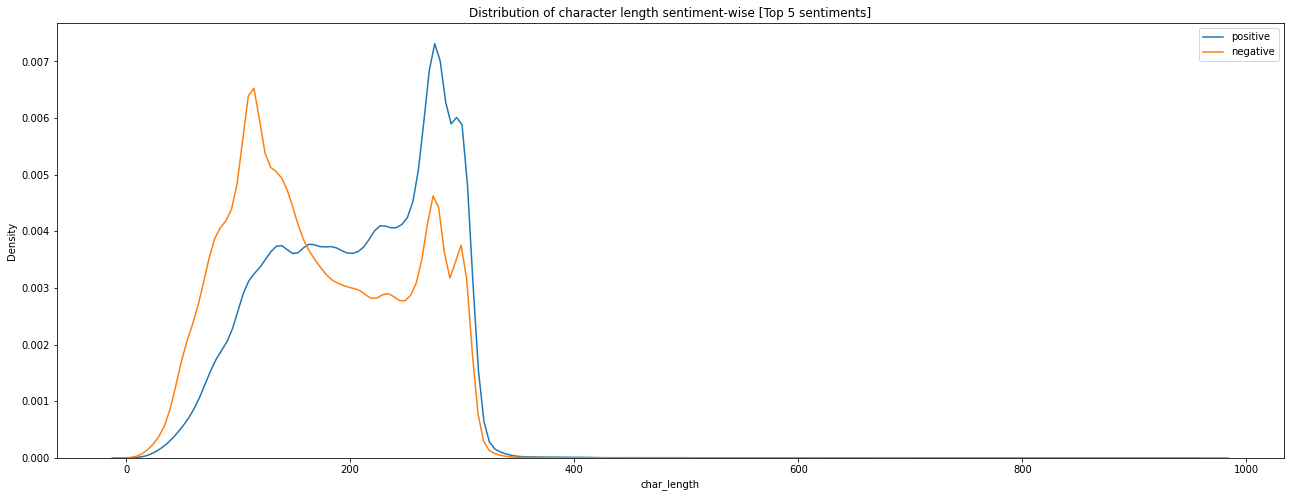

In [14]:
fig, ax = plt.subplots(figsize=(22,8))
for sentiment in df['sentiment'].value_counts().sort_values()[-5:].index.tolist():
    #print(sentiment)
    sns.kdeplot(df[df['sentiment']==sentiment]['char_length'],ax=ax, label=sentiment)
ax.legend()
ax.set_title("Distribution of character length sentiment-wise [Top 5 sentiments]")
plt.show()

In [15]:
avg_df = df.groupby('sentiment').agg({'char_length':'mean', 'token_length':'mean'})

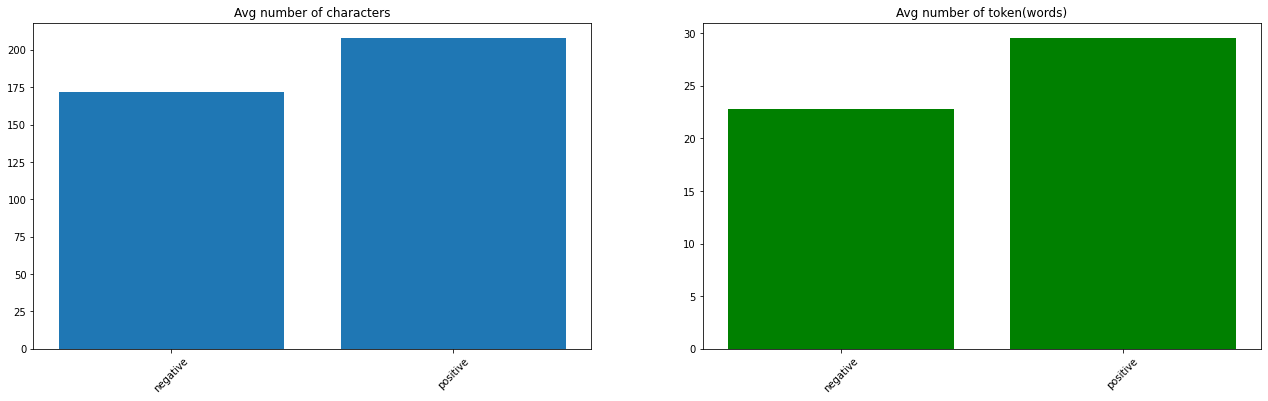

In [16]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(22,6))
ax1.bar(avg_df.index, avg_df['char_length'])
ax2.bar(avg_df.index, avg_df['token_length'], color='green')
ax1.set_title('Avg number of characters')
ax2.set_title('Avg number of token(words)')
ax1.set_xticklabels(avg_df.index, rotation = 45)
ax2.set_xticklabels(avg_df.index, rotation = 45)
plt.show()

In [17]:
pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 887.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [18]:
import neattext.functions as nfx

In [19]:
df.tail()

,created_at,file_name,followers,friends,group_name,location,retweet_count,screenname,search_query,text,twitter_id,username,polarity,partition_0,partition_1,sentiment,char_length,token_length
266090,2020-10-03 23:54:59,Youtube,176,9,Youtube,NaN,0,asian_view,#Youtube,New vlog arrivals! Discover a lovely culture t...,1312541692046667777,Asian View,0.9167,Technology,Youtube,positive,205,29
266091,2020-10-03 23:54:54,Youtube,308,567,Youtube,London UK,1,Kaiu24,#Youtube,New Video is up. Finally showing my new Stream...,1312541667703033858,Kaiu24,0.3182,Technology,Youtube,negative,264,40
266092,2020-10-03 23:54:53,Youtube,27,101,Youtube,"England, United Kingdom",0,RyanDeebo,#Youtube,NEW VIDEO!! FRIEND v FRIEND CHALLENGE!! ht...,1312541664494444544,RyanDeebo,0.9015,Technology,Youtube,positive,160,21
266093,2020-10-03 23:54:45,Youtube,110,171,Youtube,NaN,0,monay_crystal,#Youtube,‼️NEW VIDEO‼️ Films inspired by Jodorowskys Du...,1312541633603395584,Those 2! REACTS On YouTube💕😘,0.5411,Technology,Youtube,positive,292,34
266094,2020-10-03 23:54:30,Youtube,110,171,Youtube,NaN,0,monay_crystal,#Youtube,‼️NEW VIDEO‼️ Films inspired by Jodorowskys Du...,1312541567626993666,Those 2! REACTS On YouTube💕😘,0.5411,Technology,Youtube,positive,292,34


In [20]:
dir(nfx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

# Text Cleaning

In [21]:
df['Clean_Text'] = df['text'].apply(nfx.remove_userhandles)

In [22]:
df['Clean_Text'] = df['Clean_Text'].apply(nfx.remove_stopwords)

In [23]:
df['Clean_Text'] = df['Clean_Text'].apply(nfx.remove_emails)
df['Clean_Text'] = df['Clean_Text'].apply(nfx.remove_emojis)
df['Clean_Text'] = df['Clean_Text'].apply(nfx.remove_special_characters)
df['Clean_Text'] = df['Clean_Text'].apply(nfx.remove_urls)

In [24]:
df['Clean_Text'] = df['Clean_Text'].apply(str.lower)

In [25]:
df['Clean_Text']

0         nvidia gaugan actually good tool practice comp...
1         bullsequana x2415 supercomputer blade server e...
2         im going attend gtc 2020 tonight excited nvidi...
3         nvidia delays launch geforce rtx 3070 end octo...
4         bullsequana x2415 supercomputer blade server e...
                                ...                        
266090    new vlog arrivals discover lovely culture trea...
266091    new video up finally showing new streaming pc ...
266092    new video friend v friend challenge httpstcodo...
266093    new video films inspired jodorowskys dune reac...
266094    new video films inspired jodorowskys dune reac...
Name: Clean_Text, Length: 266095, dtype: object

In [26]:
df = df.sample(frac = 1)
df

,created_at,file_name,followers,friends,group_name,location,retweet_count,screenname,search_query,text,twitter_id,username,polarity,partition_0,partition_1,sentiment,char_length,token_length,Clean_Text
118852,2020-09-22 02:12:12,Twitch,124,149,Twitch,"Georgia, USA",0,KingAlunox,#Twitch,Live 🔴 now unless were not. Young boy is havin...,1308227568106172421,KingAlunox,-0.6705,Technology,Twitch,negative,184,33,live not young boy rough night stop stream ca...
23205,2020-10-08 19:17:03,Amazon,74464,70496,Amazon,online @ booktweeter.com,0,BookTweeter,#Amazon OR #AWS,"""5 Secrets of Story Structure: How to Write a ...",1314283683784916992,BookTweeter,0.3182,Technology,Amazon,negative,169,23,5 secrets story structure write novel stands o...
176883,2020-09-23 02:41:08,Tesla,124,126,Tesla,Global,0,SachivM99,#Tesla,Tesla created a battery that might someday pow...,1308597238264979461,Sachiv Mehta,0.7506,Technology,Tesla,positive,246,40,tesla created battery someday power car take ...
222432,2020-10-08 22:29:05,Netflix,4574,777,Netflix,"Walled Lake ➡️ Kalamazoo, MI",0,3rynn_Mckay,#Netflix,The split moment of sadness you get when you f...,1314332010526244876,Erynn McKay,0.2960,Technology,Netflix,negative,75,15,split moment sadness finish great netflix
84337,2020-09-30 21:33:06,Google,136,337,Google,"Shipshewana, IN",1,BAmishFurniture,#Google,Brandenberry Amish Furniture on #Google https:...,1311418820087689216,Brandenberry,0.0000,Technology,Google,negative,63,6,brandenberry amish furniture google httpstcob2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261519,2020-10-10 05:24:26,Microsoft,127,0,Microsoft,NaN,3,CT_Intelligence,#Microsoft,#Microsoft #Zerologon #Flaw (CVE20201472) Unde...,1314798925472247809,Cyber Threat Intel,-0.4767,Technology,Microsoft,negative,218,25,microsoft zerologon flaw cve20201472 attack ir...
196368,2020-10-07 14:03:38,Apple,19800,4491,Apple,Ebay Esty & Amazon #onlineshop,0,ruby_redsky,#Apple OR #Iphone,Go screw yourself https://t.co/DyuNWb0ZmQ http...,1313842423420854274,Ruby-Redsky,-0.1027,Technology,Apple,negative,135,12,screw httpstcodyunwb0zmq http wwwredbubblecomp...
170968,2020-10-09 02:40:10,Apple,10,21,Apple,NaN,1,ArmandFaguy,#Apple OR #Iphone,"#Apple, #iTunes are thieves and I can prove it...",1314395197904740353,Armand Faguy,-0.8513,Technology,Apple,negative,190,30,apple itunes thieves prove it stolen 160 itune...
141017,2020-10-11 18:32:40,Apple,1401,5001,Apple,NaN,1,fantasy_global,#Apple OR #Iphone,Get access to millions of songs with Apple Mus...,1315359678377988097,FantasySportsGlobal,0.0000,Technology,Apple,negative,111,15,access millions songs apple music httpstcosg9a...


# Building Classification Models For Sentiment Analysis

In [27]:
Xfeatures = df['Clean_Text']
ylabels = df['sentiment']

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.feature_extraction.text import TfidfTransformer
x_train,x_test,y_train,y_test = train_test_split(Xfeatures,ylabels,test_size=0.2,random_state=100)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Transformers

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [30]:
pipe_dt = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(random_state=100))])

In [31]:
pipe_dt.fit(x_train,y_train)
pipe_dt.score(x_test,y_test)

0.8850786373287736

In [32]:
sentiment_to_number = {
    'positive':1,
    'negative':0
}

In [33]:
y_train = y_train.map(sentiment_to_number)
y_test = y_test.map(sentiment_to_number)

In [34]:
from xgboost import XGBClassifier
pipe_xg = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
            ('clf', XGBClassifier(n_estimators=300,random_state=100))])

pipe_xg.fit(x_train,y_train)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=300, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=100,

In [35]:
pipe_xg.score(x_test,y_test)

0.9031736785734418

# Sentiment Analysis with Vader

In [36]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [37]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [38]:
df['sentiment'] = df['Clean_Text'].apply(lambda x : sid.polarity_scores(x)['compound'])

In [39]:
df.head()

,created_at,file_name,followers,friends,group_name,location,retweet_count,screenname,search_query,text,twitter_id,username,polarity,partition_0,partition_1,sentiment,char_length,token_length,Clean_Text
118852,2020-09-22 02:12:12,Twitch,124,149,Twitch,"Georgia, USA",0,KingAlunox,#Twitch,Live 🔴 now unless were not. Young boy is havin...,1308227568106172421,KingAlunox,-0.6705,Technology,Twitch,-0.5106,184,33,live not young boy rough night stop stream ca...
23205,2020-10-08 19:17:03,Amazon,74464,70496,Amazon,online @ booktweeter.com,0,BookTweeter,#Amazon OR #AWS,"""5 Secrets of Story Structure: How to Write a ...",1314283683784916992,BookTweeter,0.3182,Technology,Amazon,0.4588,169,23,5 secrets story structure write novel stands o...
176883,2020-09-23 02:41:08,Tesla,124,126,Tesla,Global,0,SachivM99,#Tesla,Tesla created a battery that might someday pow...,1308597238264979461,Sachiv Mehta,0.7506,Technology,Tesla,0.6808,246,40,tesla created battery someday power car take ...
222432,2020-10-08 22:29:05,Netflix,4574,777,Netflix,"Walled Lake ➡️ Kalamazoo, MI",0,3rynn_Mckay,#Netflix,The split moment of sadness you get when you f...,1314332010526244876,Erynn McKay,0.2960,Technology,Netflix,0.2960,75,15,split moment sadness finish great netflix
84337,2020-09-30 21:33:06,Google,136,337,Google,"Shipshewana, IN",1,BAmishFurniture,#Google,Brandenberry Amish Furniture on #Google https:...,1311418820087689216,Brandenberry,0.0000,Technology,Google,0.0000,63,6,brandenberry amish furniture google httpstcob2...


In [40]:
def vader_sentiment_to_categories(sentiment):
    if sentiment == 0:
        return 'Neutral'
    elif sentiment >= 0.5:
        return 'Positive'
    else:
        return 'Negative'
        

In [41]:
df['sentiment'] = df['sentiment'].apply(vader_sentiment_to_categories)

In [42]:
df.head()

,created_at,file_name,followers,friends,group_name,location,retweet_count,screenname,search_query,text,twitter_id,username,polarity,partition_0,partition_1,sentiment,char_length,token_length,Clean_Text
118852,2020-09-22 02:12:12,Twitch,124,149,Twitch,"Georgia, USA",0,KingAlunox,#Twitch,Live 🔴 now unless were not. Young boy is havin...,1308227568106172421,KingAlunox,-0.6705,Technology,Twitch,Negative,184,33,live not young boy rough night stop stream ca...
23205,2020-10-08 19:17:03,Amazon,74464,70496,Amazon,online @ booktweeter.com,0,BookTweeter,#Amazon OR #AWS,"""5 Secrets of Story Structure: How to Write a ...",1314283683784916992,BookTweeter,0.3182,Technology,Amazon,Negative,169,23,5 secrets story structure write novel stands o...
176883,2020-09-23 02:41:08,Tesla,124,126,Tesla,Global,0,SachivM99,#Tesla,Tesla created a battery that might someday pow...,1308597238264979461,Sachiv Mehta,0.7506,Technology,Tesla,Positive,246,40,tesla created battery someday power car take ...
222432,2020-10-08 22:29:05,Netflix,4574,777,Netflix,"Walled Lake ➡️ Kalamazoo, MI",0,3rynn_Mckay,#Netflix,The split moment of sadness you get when you f...,1314332010526244876,Erynn McKay,0.2960,Technology,Netflix,Negative,75,15,split moment sadness finish great netflix
84337,2020-09-30 21:33:06,Google,136,337,Google,"Shipshewana, IN",1,BAmishFurniture,#Google,Brandenberry Amish Furniture on #Google https:...,1311418820087689216,Brandenberry,0.0000,Technology,Google,Neutral,63,6,brandenberry amish furniture google httpstcob2...


# Vader Sentiment Output Distribution

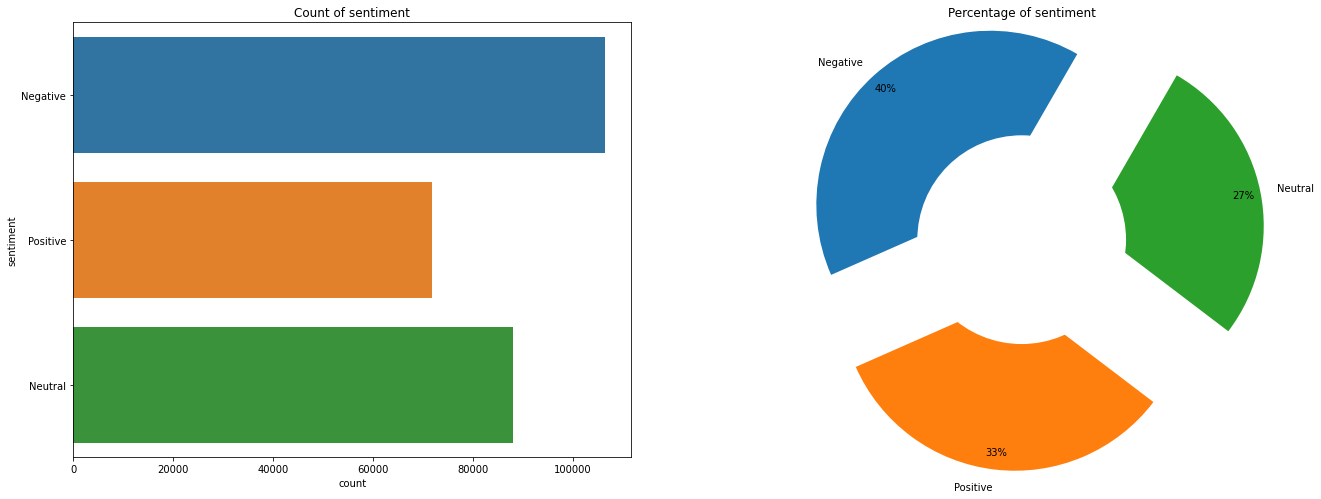

In [43]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(22,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1)
ax1.set_title("Count of sentiment")
ax2.set_title("Percentage of sentiment")
plt.show()

# Checking out some of the Outputs

In [44]:
print(df.iloc[177]['text'],'\nSentiment: ',df.iloc[177]['sentiment'])

I have not been streaming as much lately as i did in the past.  There was a time i used to stream almost every day for about 2 or 3 years but i dont feel like that atm. Somehow i dont feel myself lately, i hope i can get back into it. #streaming #twitch 
Sentiment:  Negative


In [45]:
print(df.iloc[127]['text'],'\nSentiment: ',df.iloc[127]['sentiment'])

Some cross play PEXIN' with the old PS4 gang :D totally non toxic and rage free MW and maybe VALORANT later...I swear :/ #twitch #apexlegends #modernwarfare #valorant #fridaynightmike #soupszn https://t.co/UD8MeByH9z 
Sentiment:  Negative


In [46]:
print(df.iloc[217]['text'],'\nSentiment: ',df.iloc[217]['sentiment'])

#AMD EPYC Processors Deployed with Over 2 Petaflops of Computing Power — Okinawa Institute of Science and Technology Graduate University (OIST) announced the deployment of AMD EPYC 7702 processors for use in a new, high performance computing system.  https://t.co/XthVNuAllP  #HPC https://t.co/4vQJrvNwup 
Sentiment:  Neutral
